In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from tqdm.autonotebook import tqdm
import seaborn as sns
from IGT.environments import IGTEnv, NonStochasticBanditEnv
from IGT.train import train
from STN_GPe.analysis import Analysis
from STN_GPe.stngpe import STN_GPe_loop
from STN_GPe.utils import load_yaml
from numpy.fft import fft, ifft
from STN_GPe.dbs import GenerateDBS
import pickle
from collections import defaultdict

C:\Users\Sandeep\AppData\Local\Temp\ipykernel_17340\390614340.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## PARAMS

In [2]:
# ENV params
NUM_ARMS = 3
MEAN_REWARD = np.array([10,20,40])
REW_STD = np.array([100,100,100])
SCALING_FACTOR = 100

# Training params
TRAILS = 100
EPOCHS = 25
BINS = 5
LR = 1e-1 #5e-2 #1e-2 #5e-2

# METRICS
LAST_NUM_PICKS_ = 10 # last how many picks to be considered

# D2_AMP
D2_AMP = 0.3

In [3]:
GPI_VARAINCE = [0.0, 1e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7e-2, 9e-2, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 1, 2, 5]
ARM_MONITOR = defaultdict(dict)
NUM_ARM_PICKS_MONITOR = defaultdict(dict)
PERCENTAGE_PICKS_MONITOR = defaultdict(dict)
AVG_PERCENTAGE_PICKS_MONITOR = defaultdict(dict)
DP_MONITOR = defaultdict(dict)
IP_MONITOR = defaultdict(dict)
REWARD_MONITOR = defaultdict(dict)

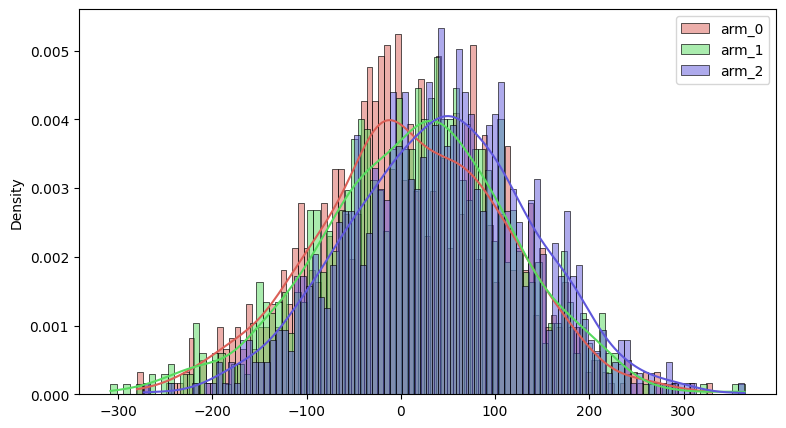

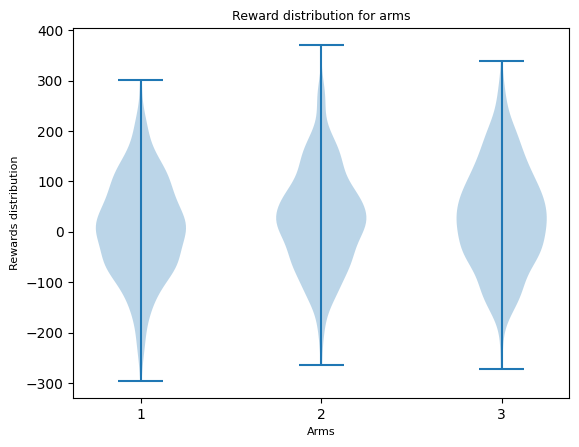

<Figure size 640x480 with 0 Axes>

In [4]:
env = NonStochasticBanditEnv(num_arms=NUM_ARMS, 
                    mean_reward=MEAN_REWARD, 
                    std = REW_STD)

env.plot_arms_reward_distribution()
env.plot_arms()

In [5]:
for var in tqdm(GPI_VARAINCE):
    env = NonStochasticBanditEnv(num_arms=NUM_ARMS, 
                       mean_reward=MEAN_REWARD/SCALING_FACTOR, 
                       std = REW_STD/SCALING_FACTOR)
    
    reward_monitor, arm_chosen_monitor, avg_counts,ip_monitor, dp_monitor,_ = train(env, 
                                                    trails = TRAILS, 
                                                    epochs = EPOCHS, 
                                                    lr = LR, 
                                                    bins = BINS,
                                                    STN_spike_output = None,
                                                    d1_amp=0.4,
                                                    d2_amp=D2_AMP, 
                                                    gpi_threshold=0.4, 
                                                    max_gpi_iters=50,
                                                    STN_neurons=5,
                                                    stn_mean= 0.0, 
                                                    stn_std = 5,
                                                    del_lim=None, train_IP = True, 
                                                    del_med = None, printing = False,
                                                    gpi_mean= 1, gpi_var = var)
    ARM_MONITOR[var] = arm_chosen_monitor
    REWARD_MONITOR[var] = reward_monitor
    # arms picked in last 10 trails
    picks = arm_chosen_monitor[:,TRAILS-LAST_NUM_PICKS_:TRAILS]

    for i in range(NUM_ARMS):
        NUM_ARM_PICKS_MONITOR[var][i] = torch.sum(picks ==i, dim = 1)
        PERCENTAGE_PICKS_MONITOR[var][i] = (NUM_ARM_PICKS_MONITOR[var][i]/LAST_NUM_PICKS_) * 100
        AVG_PERCENTAGE_PICKS_MONITOR[var][i] = torch.mean(PERCENTAGE_PICKS_MONITOR[var][i])

        DP_MONITOR[var][i] = torch.mean(dp_monitor[i], dim = 0).squeeze().detach().numpy()
        IP_MONITOR[var][i] = torch.mean(ip_monitor[i], dim = 0).squeeze().detach().numpy()
    print(f'GPi variance: {var}, Percentages: {AVG_PERCENTAGE_PICKS_MONITOR[var]}')

  0%|          | 0/20 [00:00<?, ?it/s]

Using Random noise
GPi variance: 0.0, Percentages: {0: tensor(40.), 1: tensor(24.4000), 2: tensor(35.6000)}
Using Random noise
GPi variance: 0.001, Percentages: {0: tensor(40.), 1: tensor(14.8000), 2: tensor(45.2000)}
Using Random noise
GPi variance: 0.005, Percentages: {0: tensor(40.), 1: tensor(20.), 2: tensor(40.)}
Using Random noise
GPi variance: 0.01, Percentages: {0: tensor(4.), 1: tensor(32.), 2: tensor(64.)}
Using Random noise
GPi variance: 0.02, Percentages: {0: tensor(12.8000), 1: tensor(10.4000), 2: tensor(76.8000)}
Using Random noise
GPi variance: 0.05, Percentages: {0: tensor(0.), 1: tensor(20.), 2: tensor(80.)}
Using Random noise
GPi variance: 0.07, Percentages: {0: tensor(12.4000), 1: tensor(16.4000), 2: tensor(71.2000)}
Using Random noise
GPi variance: 0.09, Percentages: {0: tensor(2.4000), 1: tensor(18.8000), 2: tensor(78.8000)}
Using Random noise
GPi variance: 0.1, Percentages: {0: tensor(9.2000), 1: tensor(17.6000), 2: tensor(73.2000)}
Using Random noise
GPi variance

# RESULTS

### SUCCESS RATE

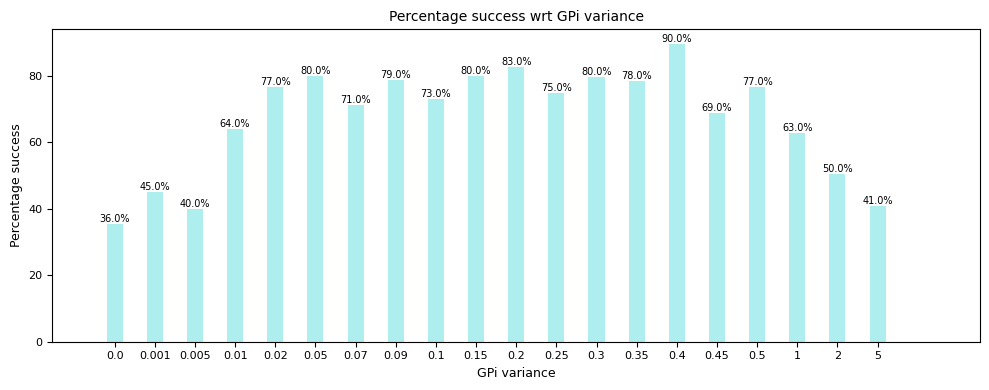

In [6]:
#percentage success plots
SUCCESS_RATE = [AVG_PERCENTAGE_PICKS_MONITOR[key][2].detach().numpy() for key in AVG_PERCENTAGE_PICKS_MONITOR.keys()]
fig, ax = plt.subplots(figsize =(10, 4))
bars = plt.bar(np.arange(len(GPI_VARAINCE)), SUCCESS_RATE, width=0.4, color = 'paleturquoise')

i = 0
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate for the text (center of the bar)
        yval,  # Y-coordinate for the text (top of the bar)
        f'{np.round(SUCCESS_RATE[i])}%',  # The text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize = 7,
    )
    i += 1
plt.hlines(np.zeros(7), xmin = -0.5, xmax = len(GPI_VARAINCE)+0.5, color = 'black', linewidth = 0.5)
ax.set_xticks(np.arange(len(GPI_VARAINCE)), GPI_VARAINCE)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('GPi variance', loc = 'center', fontsize = 9)
ax.set_ylabel('Percentage success', loc = 'center', fontsize = 9)
plt.title('Percentage success wrt GPi variance', fontsize = 10)
plt.tight_layout()

### REGRET

In [7]:
MEAN_FOR_OPTIMALARM = 40/100
REGRET = TRAILS * MEAN_FOR_OPTIMALARM -  np.array([torch.sum(torch.mean(REWARD_MONITOR[var],dim =0)) for var in REWARD_MONITOR.keys()])

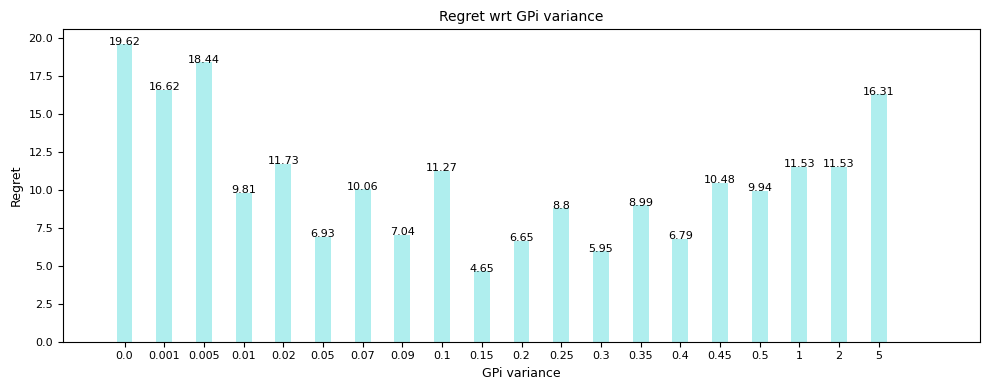

In [8]:
#percentage success plots

fig, ax = plt.subplots(figsize =(10, 4))

bars = plt.bar(np.arange(len(GPI_VARAINCE)), REGRET , width=0.4, color = 'paleturquoise')

i = 0
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width()/2,  # X-coordinate for the text (center of the bar)
        REGRET[i] + 0.5, #Y-coordinate for the text (top of the bar)
        np.round(REGRET [i],decimals = 2),  # The text to display
        ha='center',  # Horizontal alignment
        va='top',  # Vertical alignment
        fontsize = 8,

    )
    i += 1
plt.hlines(np.zeros(7), xmin = -0.5, xmax = len(GPI_VARAINCE)+0.5, color = 'black', linewidth = 0.5)
ax.set_xticks(np.arange(len(GPI_VARAINCE)), GPI_VARAINCE)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('GPi variance', loc = 'center', fontsize = 9)
ax.set_ylabel('Regret', loc = 'center', fontsize = 9)
plt.title('Regret wrt GPi variance', fontsize = 10)
plt.tight_layout()

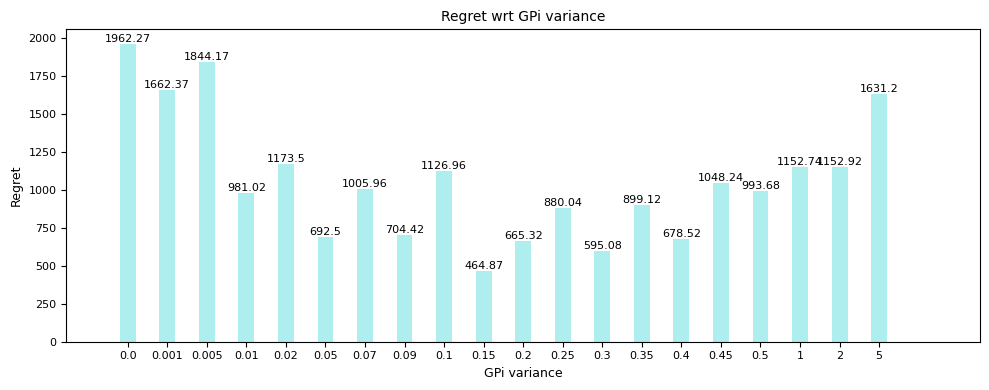

In [9]:
# Regret

fig, ax = plt.subplots(figsize =(10, 4))

bars = plt.bar(np.arange(len(GPI_VARAINCE)), REGRET * SCALING_FACTOR , width=0.4, color = 'paleturquoise')

i = 0
for bar in bars:
    yval = bar.get_height()  # Get the height of the bar
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate for the text (center of the bar)
        yval,#Y-coordinate for the text (top of the bar)
        np.round(REGRET [i]*SCALING_FACTOR, decimals=2),  # The text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Vertical alignment
        fontsize = 8,
    )

    i += 1
plt.hlines(np.zeros(7), xmin = -0.5, xmax = len(GPI_VARAINCE)+0.5, color = 'black', linewidth = 0.5)
ax.set_xticks(np.arange(len(GPI_VARAINCE)), GPI_VARAINCE)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel('GPi variance', loc = 'center', fontsize = 9)
ax.set_ylabel('Regret', loc = 'center', fontsize = 9)
plt.title('Regret wrt GPi variance', fontsize = 10)
plt.tight_layout()

Avg variance: 7.298058e-05


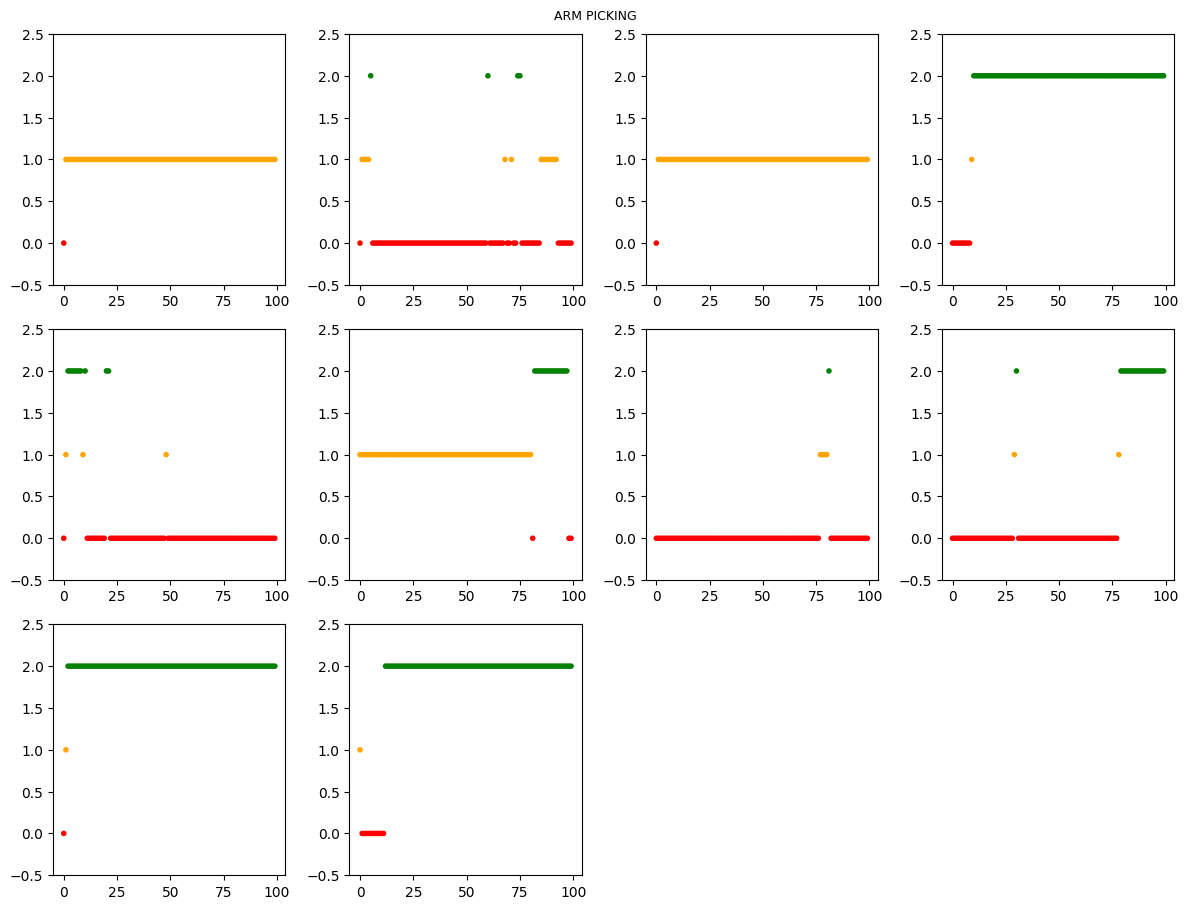

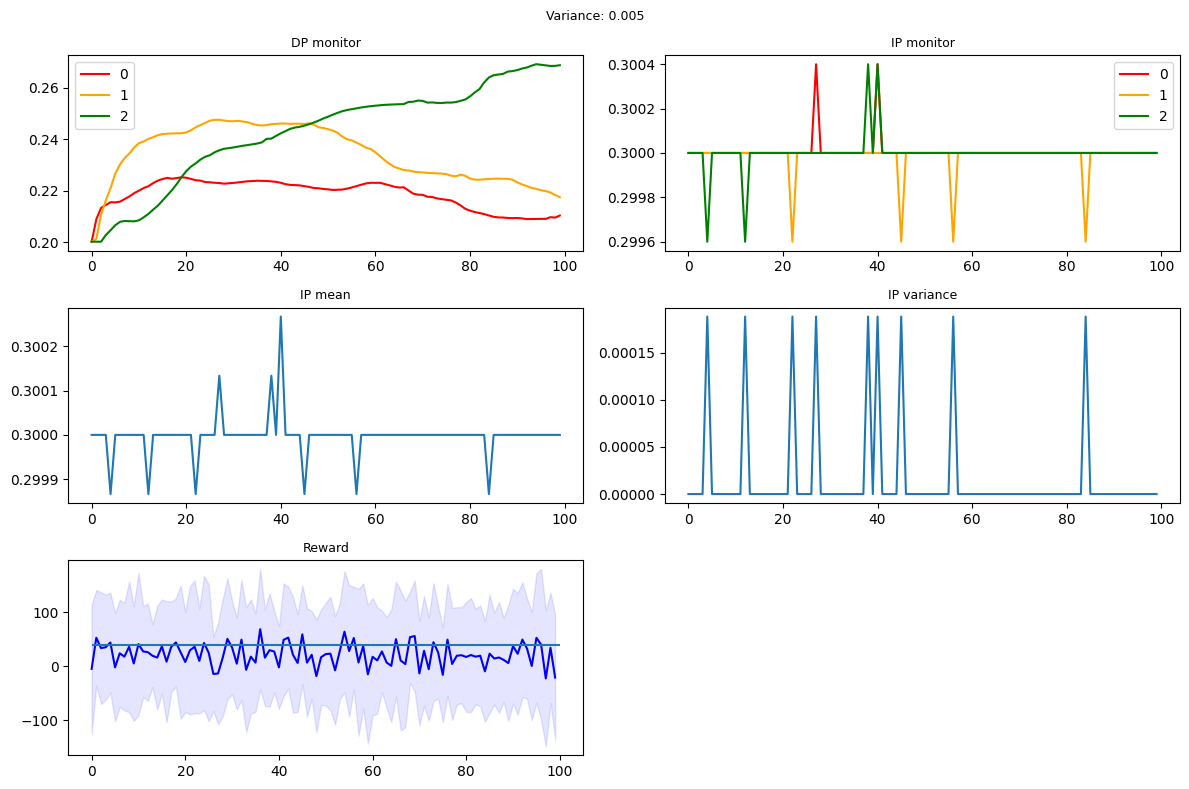

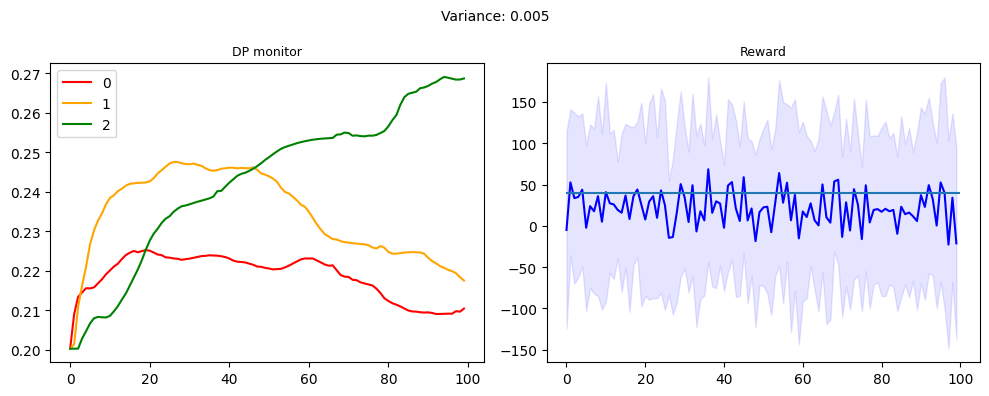

In [11]:
variance = 0.005
color_map = {0: 'red', 1: 'orange', 2: 'green'}
plt.figure(figsize=(12,12))
plt.suptitle('ARM PICKING', fontsize = 9)
for i in range(10):
    plt.subplot(4,4,i+1)
    values = ARM_MONITOR[variance][np.random.randint(0,EPOCHS)]
    # Vectorized replacement
    color_array = np.vectorize(color_map.get)(values)
    plt.scatter(np.arange(TRAILS),values, marker = '.', color = color_array)
    plt.ylim(-0.5,2.5)
plt.tight_layout()

plt.figure(figsize = (12,8))
plt.suptitle(f'Variance: {variance}', fontsize = 9)
plt.subplot(3,2,1)
for i in range(NUM_ARMS):
    plt.plot(DP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()    
plt.title('DP monitor', fontsize = 9)
plt.subplot(3,2,2)
for i in range(NUM_ARMS):
    plt.plot(IP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()
plt.title('IP monitor', fontsize = 9)

plt.subplot(3,2,3)
plt.plot(np.mean(np.array(list(IP_MONITOR[variance].values())),0))
plt.title('IP mean', fontsize = 9)

plt.subplot(3,2,4)
plt.plot(np.std(np.array(list(IP_MONITOR[variance].values())),0))
print('Avg variance:' ,np.mean(np.std(np.array(list(IP_MONITOR[variance].values())))))
plt.title('IP variance', fontsize = 9)

plt.subplot(3,2,5)
mean_rew = torch.mean(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
std_rew = torch.std(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
plt.plot(np.arange(TRAILS), mean_rew, color = 'blue')
plt.fill_between(np.arange(TRAILS), y1 = mean_rew - std_rew, y2 = mean_rew + std_rew, alpha = 0.1, color = 'blue')
plt.title('Reward', fontsize = 9)
plt.hlines(y = 40, xmin = 0, xmax = TRAILS)
plt.tight_layout()



plt.figure(figsize = (10,4))
plt.suptitle(f'Variance: {variance}', fontsize = 10)
plt.subplot(1,2,1)
for i in range(NUM_ARMS):
    plt.plot(DP_MONITOR[variance][i], color = color_map[i], label = i)
    plt.legend()    
plt.title('DP monitor', fontsize = 9)
plt.subplot(1,2,2)
mean_rew = torch.mean(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
std_rew = torch.std(REWARD_MONITOR[variance],dim =0) * SCALING_FACTOR
plt.plot(np.arange(TRAILS), mean_rew, color = 'blue')
plt.fill_between(np.arange(TRAILS), y1 = mean_rew - std_rew, y2 = mean_rew + std_rew, alpha = 0.1, color = 'blue')
# plt.ylim(0,100)
plt.title('Reward', fontsize = 9)
plt.hlines(y = 40, xmin = 0, xmax = TRAILS)
plt.tight_layout()